# Lecture 18 - Contrastive Learning for Experimental Chemistry

```{contents}
:local:
:depth: 1
```

**Learning goals**

- Understand the idea of **contrastive learning**.
- Construct **positive pairs** and **negative pairs** using easy augmentations that mimic lab variability.
- Write and inspect a **InfoNCE loss** with small arrays before touching any model.
- Practice designing **augmentations** for spectra and reaction conditions.



## 1. Setup

In [1]:
# 1. Setup
import os, math, sys, textwrap, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional scientific extras
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception:
    torch = None

# Optional chemistry toolkit
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(18)

# Plot defaults
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["axes.grid"] = True

In [2]:
def show_shape(name, x):
    if hasattr(x, "shape"):
        print(f"{name}.shape:", x.shape)
    else:
        print(f"{name}: (no .shape) type={type(x)}")

def head(arr, n=3, name="arr"):
    print(f"{name} head:")
    print(np.asarray(arr)[:n])

---

## 2. Contrastive learning idea in a chemistry setting

Why contrastive learning?
In many lab projects, positive results are rare and negatives are mixed with non-attempts.  
Contrastive learning can pretrain an embedding using instance agreement without needing full labels, then a small labeled set can train a light classifier on top.

The basic objective is simple: samples that are **different views of the same underlying item** should be **close** in the embedding, while **different items** should be **far**.

- A view can be a small transformation that preserves identity.  
- In chemistry we can mimic instrument noise, baseline drift, slight temperature jitter, or solvent variations that do not change the label of interest.

We will keep the math light and the code step-by-step.

### 2.1 What is a positive pair and a negative pair

- **Positive pair**: two views of the same experiment or the same molecule.  
- **Negative pair**: two views that come from different experiments or different molecules.

Example labels for a toy case:
- An experiment that yields the product with high purity.  
- Two instruments that read the same sample but with slight noise.  
These two readings form a **positive pair**. Two readings from different samples form a **negative pair**.

### 2.2 Cosine similarity

Cosine similarity measures the angle between vectors. It is large when vectors point in the same direction.

$
\operatorname{cos\_sim}(u,v)=\frac{u\cdot v}{\|u\|\,\|v\|}
$

We use it because the magnitude is not as important as the direction in many embedding spaces.

In [3]:
# Cosine similarity in NumPy
def cos_sim(u, v, eps=1e-8):
    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)
    num = np.dot(u, v)
    den = np.linalg.norm(u) * np.linalg.norm(v) + eps
    return float(num / den)

a = np.array([1.0, 0.0])
b = np.array([0.8, 0.2])
c = np.array([-1.0, 0.0])

print("cos(a,b) =", cos_sim(a,b))
print("cos(a,c) =", cos_sim(a,c))

cos(a,b) = 0.970142488380626
cos(a,c) = -0.9999999900000002


```{admonition} Exercise 2.2
Normalize vectors `a` and `b` by dividing by their norms.  
Confirm that cosine similarity does not change after normalization.
```

---

## 3. A simple 2D chemistry example and visualization

We simulate two experiment classes.  
Think of them as two reaction regimes.  
Each point is a pair of features:
- $x_0$ behaves like a normalized temperature.  
- $x_1$ behaves like a solvent family flag that you can think of as 0 or 1 with small jitter for plotting.

### 3.1 Generate a small dataset

In [4]:
# 2D toy dataset with two regimes
n_pos = 120
n_neg = 120

x_pos = np.column_stack([
    rng.normal(0.70, 0.08, n_pos),
    np.clip(rng.normal(0.95, 0.05, n_pos), 0.0, 1.0)
])

x_neg = np.column_stack([
    rng.normal(0.40, 0.10, n_neg),
    np.clip(rng.normal(0.10, 0.06, n_neg), 0.0, 1.0)
])

X = np.vstack([x_pos, x_neg]).astype(np.float32)
y = np.hstack([np.ones(n_pos, dtype=int), np.zeros(n_neg, dtype=int)])

show_shape("X", X)
head(X, name="X")

X.shape: (240, 2)
X head:
[[0.6654 0.9177]
 [0.6096 0.9834]
 [0.7539 0.981 ]]


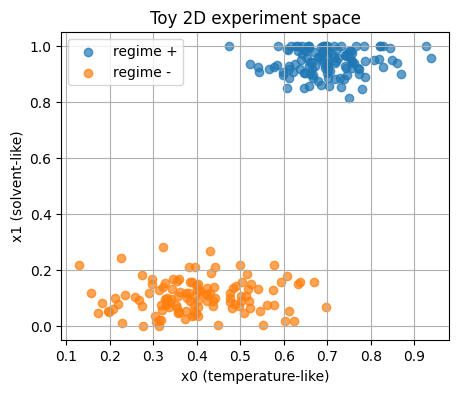

In [5]:
# Plot the two groups
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], alpha=0.7, label="regime +")
plt.scatter(X[y==0,0], X[y==0,1], alpha=0.7, label="regime -")
plt.xlabel("x0 (temperature-like)")
plt.ylabel("x1 (solvent-like)")
plt.title("Toy 2D experiment space")
plt.legend()
plt.show()

```{admonition} Tip
When you plot a 2D toy example, you can see quickly if your method is grouping things in a way that makes sense.  
In this lecture, 2D plots will be used very often with short code cells.
```

### 3.2 Simple train and test split

We keep a fixed split for repeatability.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=18, stratify=y
)
print("Train size:", len(X_train), " Test size:", len(X_test))

Train size: 180  Test size: 60


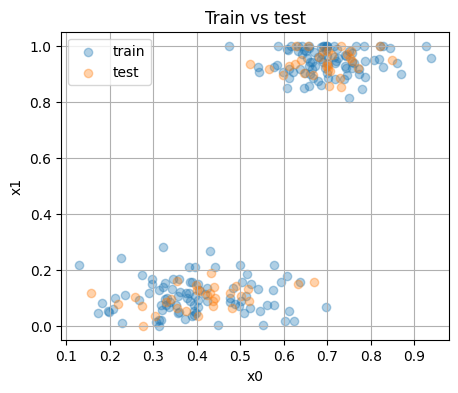

In [7]:
# Visualize the split
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.35, label="train")
plt.scatter(X_test[:,0],  X_test[:,1],  alpha=0.35, label="test")
plt.xlabel("x0")
plt.ylabel("x1")
plt.title("Train vs test")
plt.legend()
plt.show()

```{admonition} Exercise 3.2
Change the `random_state` in the split from 18 to 5.  
Rebuild the plot and see how the scatter changes while the distributions remain similar.
```

---

## 4. Building positive and negative pairs with easy augmentations

Contrastive learning needs pairs.  
We will define augmentations that keep the identity of the same sample.  
These are small changes that simulate instrument noise or small condition jitter.

### 4.1 Augmentations for the toy 2D data

In [8]:
def jitter(x, noise_std=0.02):
    x = np.asarray(x, dtype=float)
    return x + rng.normal(0.0, noise_std, size=x.shape)

def small_rotation(x, angle_std_deg=8.0):
    # Rotate 2D point around origin by a small random angle in degrees
    theta = np.deg2rad(rng.normal(0.0, angle_std_deg))
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return (R @ x.reshape(2,1)).ravel()

def clip01(x):
    return np.clip(x, 0.0, 1.0)

def augment_view(x):
    # One simple pipeline: jitter then a tiny rotation, then clip to [0,1]
    return clip01(small_rotation(jitter(x, 0.02), 6.0))

In [9]:
# Show one point and two views
x0 = X_train[0]
v1 = augment_view(x0)
v2 = augment_view(x0)

print("Original:", x0)
print("View1   :", v1)
print("View2   :", v2)

Original: [0.6845 0.8594]
View1   : [0.6846 0.8167]
View2   : [0.7649 0.7075]


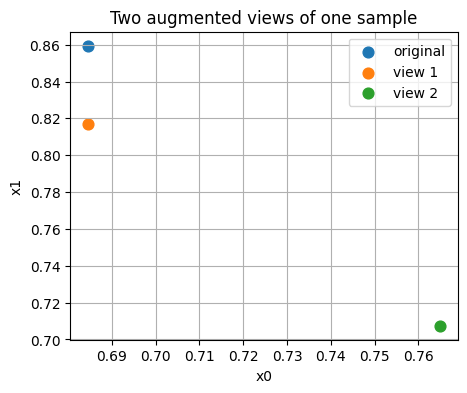

In [10]:
# Visualize the two views and the original
plt.figure()
plt.scatter([x0[0]], [x0[1]], s=60, label="original")
plt.scatter([v1[0]], [v1[1]], s=60, label="view 1")
plt.scatter([v2[0]], [v2[1]], s=60, label="view 2")
plt.legend()
plt.title("Two augmented views of one sample")
plt.xlabel("x0"); plt.ylabel("x1")
plt.show()

```{admonition} Exercise 4.1
Increase `noise_std` in `jitter` to `0.05`.  
Run the same cell again to see how far the views move.  
Discuss if this still preserves the identity of the sample.
```

### 4.2 Build a small batch of pairs

We now collect a tiny batch from the training set for demonstration.  
We will keep it small to print everything clearly.

In [11]:
batch_idx = np.arange(8)  # first eight points
xb = X_train[batch_idx]

# Create two views for each item
xa = np.array([augment_view(x) for x in xb])
xb2 = np.array([augment_view(x) for x in xb])

show_shape("xa", xa)
show_shape("xb2", xb2)
head(xa, name="xa")

xa.shape: (8, 2)
xb2.shape: (8, 2)
xa head:
[[0.537  0.9773]
 [0.4132 0.1257]
 [0.5364 0.0877]]


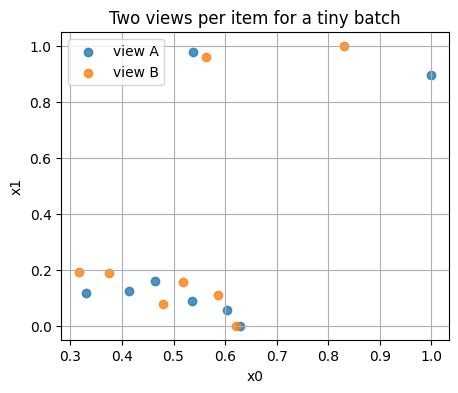

In [12]:
# Plot the two views for the mini-batch
plt.figure()
plt.scatter(xa[:,0],  xa[:,1],  label="view A", alpha=0.8)
plt.scatter(xb2[:,0], xb2[:,1], label="view B", alpha=0.8)
plt.title("Two views per item for a tiny batch")
plt.xlabel("x0"); plt.ylabel("x1")
plt.legend()
plt.show()

```{admonition} What counts as a negative here
For a given anchor in view A, all other items in view B act as negatives.  
We do not need explicit negative labels, the batch itself supplies them.
```

```{admonition} Exercise 4.2
Change `batch_idx` from the first 8 to a slice like `np.arange(8, 16)`.  
Plot again and compare.  
Do the points look similar across views?
```

---

## 5. InfoNCE loss step-by-step

The InfoNCE loss is a popular choice in contrastive learning.  
It promotes high similarity for the correct positive pair and low similarity to others.  
We will compute it from scratch on small arrays.

### 5.1 Normalize and compute pairwise cosine similarities

The encoder network is not required yet.  
We only take the two views `xa` and `xb2`, normalize them, then compute a similarity matrix.

In [13]:
def l2_normalize_rows(M, eps=1e-9):
    M = np.asarray(M, dtype=float)
    norms = np.linalg.norm(M, axis=1, keepdims=True) + eps
    return M / norms

za = l2_normalize_rows(xa)   # embeddings for view A
zb = l2_normalize_rows(xb2)  # embeddings for view B

# Pairwise cosine similarities S[i,j] = za[i] dot zb[j]
S = za @ zb.T

show_shape("za", za)
show_shape("zb", zb)
show_shape("S", S)
print("First 3x3 block of S:\n", S[:3,:3])

za.shape: (8, 2)
zb.shape: (8, 2)
S.shape: (8, 8)
First 3x3 block of S:
 [[0.9996 0.8251 0.7152]
 [0.7354 0.9851 1.    ]
 [0.6389 0.9536 0.9913]]


```{admonition} Note
Row `i` and column `i` correspond to the positive pair for item `i`.  
Large diagonal values are good for this loss.
```

### 5.2 InfoNCE with a temperature scalar

We use a small positive constant `tau` that controls the softness of the softmax.  
Smaller `tau` makes the softmax sharper.

The per-item loss with positive at index `i` is:

$
\ell_i = -\log \frac{\exp(S_{ii}/\tau)}{\sum_{j=1}^N \exp(S_{ij}/\tau)}
$

The batch loss is the mean of $\ell_i$.

In [14]:
def info_nce_from_sim(S, tau=0.1):
    # S is an NxN similarity matrix between view A rows and view B rows
    N = S.shape[0]
    logits = S / tau
    # subtract max per row for numerical stability
    logits = logits - logits.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    denom = exp_logits.sum(axis=1, keepdims=True)
    prob_pos = exp_logits[np.arange(N), np.arange(N)] / denom.ravel()
    loss = -np.log(np.clip(prob_pos, 1e-12, 1.0)).mean()
    return float(loss), prob_pos

loss_val, ppos = info_nce_from_sim(S, tau=0.1)
print("InfoNCE loss:", round(loss_val, 4))
print("Prob of positive pair per item:", np.round(ppos, 4))

InfoNCE loss: 1.57
Prob of positive pair per item: [0.4188 0.1608 0.1827 0.1622 0.1507 0.2508 0.2065 0.2253]


```{admonition} Exercise 5.2
Change `tau` from `0.1` to `0.5` and then to `0.05`.  
Report the loss and the positive pair probabilities.  
Which value makes the model focus more on the highest similarity entries?
```

### 5.3 Symmetric loss

Often we also compute the reverse direction by swapping the roles of A and B, then average the two losses.  
This can improve stability.

In [15]:
loss_ab, _ = info_nce_from_sim(za @ zb.T, tau=0.1)
loss_ba, _ = info_nce_from_sim(zb @ za.T, tau=0.1)
print("AB direction loss:", round(loss_ab, 4))
print("BA direction loss:", round(loss_ba, 4))
print("Symmetric loss:", round((loss_ab + loss_ba)/2.0, 4))

AB direction loss: 1.57
BA direction loss: 1.5346
Symmetric loss: 1.5523


```{admonition} Tip
When debugging a new contrastive implementation, start with very small batches and print the intermediate arrays.  
You can catch indexing mistakes with human eyes before moving to larger experiments.
```

---

## 6. Optional tiny encoder if `torch` is available

This part is optional.  
If `torch` is installed, we fit a small encoder that maps 2D inputs to a 2D embedding and uses InfoNCE.  
The goal is to see the points cluster by identity rather than by raw coordinates.

In [16]:
if torch is None:
    print("PyTorch is not available. You can still run all NumPy sections.")
else:
    print("PyTorch is available. We will build a tiny encoder.")

PyTorch is available. We will build a tiny encoder.


### 6.1 Define a simple dataset and encoder

In [17]:
if torch is not None:

    class PairDataset(Dataset):
        def __init__(self, X_array, aug_fn, n_items=240):
            self.X = np.asarray(X_array, dtype=np.float32)
            self.aug_fn = aug_fn
            self.n_items = min(n_items, len(self.X))

        def __len__(self):
            return self.n_items

        def __getitem__(self, idx):
            x = self.X[idx]
            v1 = self.aug_fn(x)
            v2 = self.aug_fn(x)
            return v1.astype(np.float32), v2.astype(np.float32)

    class TinyEncoder(nn.Module):
        def __init__(self, in_dim=2, out_dim=2, hidden=32):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, out_dim),
            )
        def forward(self, x):
            z = self.net(x)
            z = F.normalize(z, p=2, dim=1)
            return z

```{admonition} Exercise 6.1
Change `hidden=32` to `hidden=8` and observe training loss.  
Does a smaller hidden layer make training slower or less stable on this toy example?
```

### 6.2 One training step split into tiny sub-steps

We compute the pairwise similarities, then the loss, then one optimizer step.  
We print shapes to keep it clear.

In [18]:
if torch is not None:
    ds = PairDataset(X_train, augment_view, n_items=len(X_train))
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    enc = TinyEncoder(in_dim=2, out_dim=2, hidden=32)
    opt = torch.optim.Adam(enc.parameters(), lr=1e-2)

    xb_a, xb_b = next(iter(dl))
    show_shape("xb_a torch", xb_a)
    show_shape("xb_b torch", xb_b)

    enc.train()
    z_a = enc(xb_a)
    z_b = enc(xb_b)

    show_shape("z_a", z_a)
    show_shape("z_b", z_b)

    # Similarity matrix
    S = z_a @ z_b.T
    tau = 0.1
    logits = S / tau
    logits = logits - logits.max(dim=1, keepdim=True).values
    exp_logits = torch.exp(logits)
    prob_pos = torch.diag(exp_logits) / exp_logits.sum(dim=1)
    loss = -torch.log(torch.clamp(prob_pos, min=1e-12)).mean()

    print("Loss (one step):", float(loss.item()))

xb_a torch.shape: torch.Size([64, 2])
xb_b torch.shape: torch.Size([64, 2])
z_a.shape: torch.Size([64, 2])
z_b.shape: torch.Size([64, 2])
Loss (one step): 4.005533695220947


In [19]:
if torch is not None:
    # Backprop once
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    print("Step done.")

Step done.


```{admonition} Exercise 6.2
Set `tau` to `0.2` inside the training cell and repeat the step.  
Did the loss change as expected compared with `tau=0.1`?
```

### 6.3 A short training loop

We split the loop across two cells to keep each piece small.  
First we define the function that computes batch loss.  
Then we run a tiny loop and record losses for a simple plot.

In [20]:
if torch is not None:
    def batch_info_nce(encoder, xb_a, xb_b, tau=0.1):
        z_a = encoder(xb_a)
        z_b = encoder(xb_b)
        S = z_a @ z_b.T
        logits = S / tau
        logits = logits - logits.max(dim=1, keepdim=True).values
        exp_logits = torch.exp(logits)
        denom = exp_logits.sum(dim=1)
        prob_pos = torch.diag(exp_logits) / denom
        loss = -torch.log(torch.clamp(prob_pos, min=1e-12)).mean()
        return loss

    # Reinit encoder for a clean run
    enc = TinyEncoder(in_dim=2, out_dim=2, hidden=32)
    opt = torch.optim.Adam(enc.parameters(), lr=1e-2)

step 000  loss=4.1400


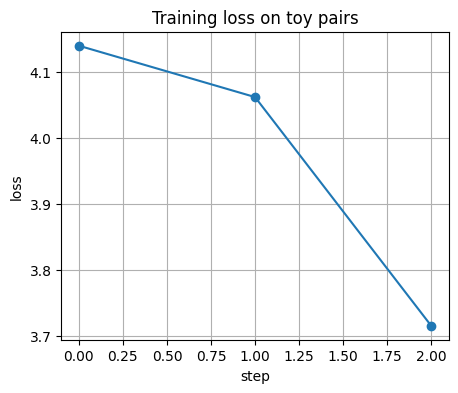

In [21]:
if torch is not None:
    losses = []
    enc.train()
    for step, (xa_b, xb_b) in enumerate(dl):
        loss = batch_info_nce(enc, xa_b, xb_b, tau=0.1)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        if step % 10 == 0:
            print(f"step {step:03d}  loss={losses[-1]:.4f}")
    plt.figure()
    plt.plot(losses, marker="o")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training loss on toy pairs")
    plt.show()

```{admonition} Exercise 6.3
Try a smaller learning rate `5e-3` and then a larger one `2e-2`.  
Does the loss curve become smoother or noisier?
```

### 6.4 Visualize the learned embedding with T-SNE

We embed the test set using the trained encoder.  
Then we color by the hidden class to see clusters.

z_test_np.shape: (60, 2)


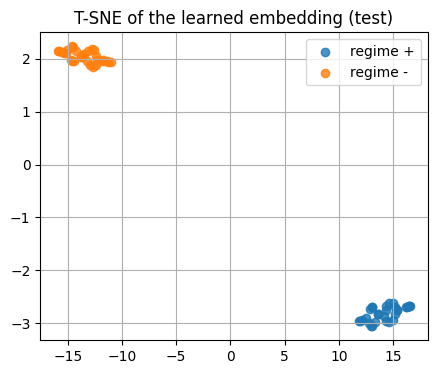

In [22]:
if torch is not None:
    enc.eval()
    with torch.no_grad():
        z_test = enc(torch.from_numpy(X_test))
        z_test_np = z_test.cpu().numpy()

    show_shape("z_test_np", z_test_np)

    # T-SNE on the learned embedding
    tsne = TSNE(n_components=2, random_state=0, perplexity=20, init="random")
    Z2 = tsne.fit_transform(z_test_np)

    plt.figure()
    plt.scatter(Z2[y_test==1,0], Z2[y_test==1,1], alpha=0.8, label="regime +")
    plt.scatter(Z2[y_test==0,0], Z2[y_test==0,1], alpha=0.8, label="regime -")
    plt.title("T-SNE of the learned embedding (test)")
    plt.legend()
    plt.show()

```{admonition} Exercise 6.4
Replace T-SNE with the raw 2D embedding `z_test_np` since it is already 2D.  
Plot directly and compare to the T-SNE view.
```

---

## 7. Linear evaluation and simple retrieval

After contrastive pretraining, a common step is **linear evaluation**.  
We freeze the encoder and train a simple classifier on top with a small labeled set.

### 7.1 Linear probe using logistic regression

In [23]:
# If torch is missing, we will use raw features as a dummy "embedding"
if torch is None:
    Z_train = X_train.copy()
    Z_test = X_test.copy()
else:
    enc.eval()
    with torch.no_grad():
        Z_train = enc(torch.from_numpy(X_train)).cpu().numpy()
        Z_test = enc(torch.from_numpy(X_test)).cpu().numpy()

show_shape("Z_train", Z_train)
show_shape("Z_test", Z_test)

Z_train.shape: (180, 2)
Z_test.shape: (60, 2)


In [24]:
sc = StandardScaler().fit(Z_train)
Ztr = sc.transform(Z_train)
Zte = sc.transform(Z_test)

clf = LogisticRegression(max_iter=500, random_state=0)
clf.fit(Ztr, y_train)

y_proba = clf.predict_proba(Zte)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

Accuracy: 1.0
AUC: 1.0


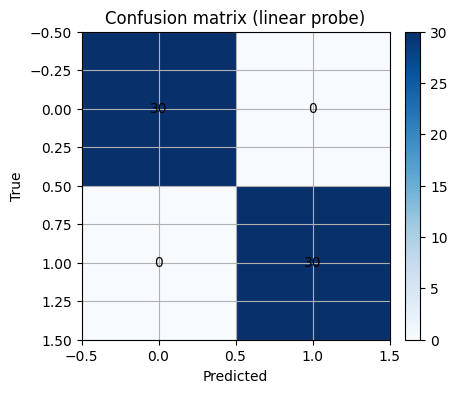

In [25]:
# Confusion matrix for a quick look
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix (linear probe)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

```{admonition} Exercise 7.1
Change the decision threshold from `0.5` to `0.3` and to `0.7`.  
Plot ROC and mark the two points.  
Discuss how the tradeoff moves.
```

### 7.2 Retrieval with cosine similarity

We take one query from the test set and retrieve the nearest neighbors in the embedding space.  
This is useful to propose similar conditions or spectra for follow up experiments.

In [26]:
def topk_cosine(query, items, k=5):
    q = query.reshape(1, -1)
    items_n = normalize(items, norm="l2", axis=1)
    q_n = normalize(q, norm="l2", axis=1)
    sims = (items_n @ q_n.T).ravel()
    idx = np.argsort(-sims)[:k]
    return idx, sims[idx]

q_idx = 2
q = Z_test[q_idx]
idx, sims = topk_cosine(q, Z_test, k=6)  # include itself

print("Query is index", q_idx, "with class", y_test[q_idx])
print("Top indices:", idx)
print("Top sims   :", np.round(sims, 3))

Query is index 2 with class 1
Top indices: [ 2 38 24 47 13 37]
Top sims   : [1. 1. 1. 1. 1. 1.]


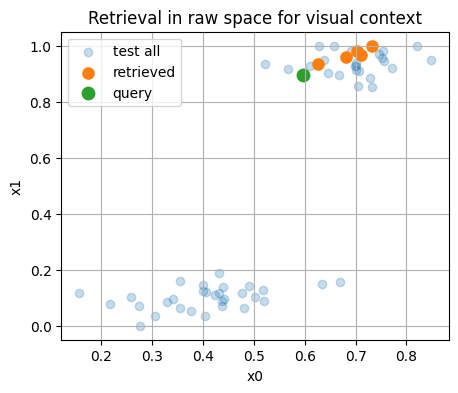

In [27]:
# Visualize query and neighbors in raw 2D space for context
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], alpha=0.25, label="test all")
plt.scatter(X_test[idx,0], X_test[idx,1], s=65, label="retrieved")
plt.scatter([X_test[q_idx,0]],[X_test[q_idx,1]], s=80, label="query")
plt.xlabel("x0"); plt.ylabel("x1")
plt.title("Retrieval in raw space for visual context")
plt.legend()
plt.show()

```{admonition} Exercise 7.2
Replace `q_idx = 2` with another index.  
Check if the nearest neighbors share the same label more often than random picks.
```

---

## 8. Chemistry-specific augmentations and mini case studies

Contrastive learning depends on good view design.  
In chemistry, the view should preserve the identity of the sample while adding realistic variation.

### 8.1 Spectra toy example: IR-like peaks with noise

We synthesize spectra as sums of Gaussians.  
Two views of the same sample will get small baseline shifts and noise.

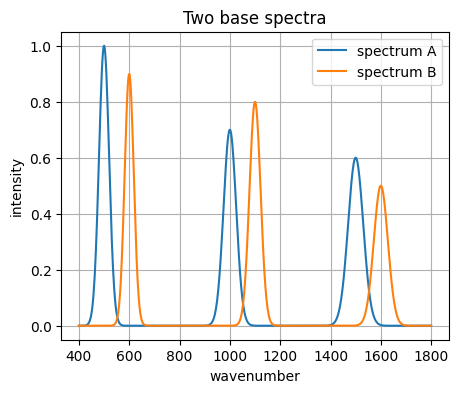

In [28]:
# Build synthetic 1D spectra
def gaussian(x, mu, sig, amp):
    return amp * np.exp(-0.5 * ((x-mu)/sig)**2)

def make_spectrum(x, peaks):
    y = np.zeros_like(x)
    for (mu, sig, amp) in peaks:
        y += gaussian(x, mu, sig, amp)
    return y

x_grid = np.linspace(400, 1800, 600)  # wavenumbers
peaks_A = [(500, 20, 1.0), (1000, 25, 0.7), (1500, 30, 0.6)]
peaks_B = [(600, 18, 0.9), (1100, 22, 0.8), (1600, 28, 0.5)]

spec_A = make_spectrum(x_grid, peaks_A)
spec_B = make_spectrum(x_grid, peaks_B)

plt.figure()
plt.plot(x_grid, spec_A, label="spectrum A")
plt.plot(x_grid, spec_B, label="spectrum B")
plt.xlabel("wavenumber")
plt.ylabel("intensity")
plt.title("Two base spectra")
plt.legend()
plt.show()

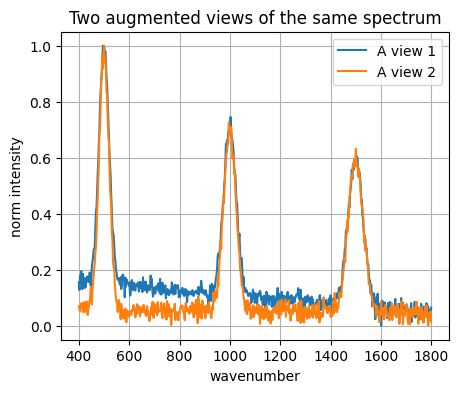

In [29]:
# Augmentations for spectra
def add_baseline(y, slope_std=0.0005):
    slope = rng.normal(0.0, slope_std)
    baseline = slope * (np.arange(len(y)) - len(y)/2.0)
    return y + baseline

def add_noise(y, std=0.02):
    return y + rng.normal(0.0, std, size=len(y))

def scale_intensity(y, s_std=0.05):
    s = 1.0 + rng.normal(0.0, s_std)
    return y * s

def normalize_minmax(y):
    ymin, ymax = y.min(), y.max()
    if ymax - ymin < 1e-9:
        return y.copy()
    return (y - ymin) / (ymax - ymin)

def view_spectrum(y):
    z = add_baseline(y, 0.0004)
    z = add_noise(z, 0.02)
    z = scale_intensity(z, 0.03)
    return normalize_minmax(z)

# Make two views for A
vA1 = view_spectrum(spec_A)
vA2 = view_spectrum(spec_A)

plt.figure()
plt.plot(x_grid, vA1, label="A view 1")
plt.plot(x_grid, vA2, label="A view 2")
plt.xlabel("wavenumber"); plt.ylabel("norm intensity")
plt.title("Two augmented views of the same spectrum")
plt.legend()
plt.show()

```{admonition} Exercise 8.1
Increase noise from `0.02` to `0.05` and watch the two curves.  
At what point do you think the identity is compromised?
```

### 8.2 Simple contrastive score for spectra without training

We can compute cosine similarity between two views of a spectrum as a quick score.  
This is not training, but the idea of agreement is already visible.

In [30]:
s_same = cos_sim(vA1, vA2)
s_diff = cos_sim(vA1, view_spectrum(spec_B))
print("cos(view of A, view of A) =", round(s_same, 3))
print("cos(view of A, view of B) =", round(s_diff, 3))

cos(view of A, view of A) = 0.977
cos(view of A, view of B) = 0.627


```{admonition} Note
You can build a practical pre-screening tool by ranking spectra pairs using cosine similarity.  
Training an encoder may improve robustness when spectra include many nuisance changes.
```

### 8.3 Reaction conditions: small jitter as views

We simulate reaction conditions as vectors `[T, time, concentration]`.  
Two views of the same setup add small jitter that keeps the label stable.

In [31]:
def augment_conditions(v, t_std=1.0, time_std=0.05, c_std=0.02):
    T = v[0] + rng.normal(0.0, t_std)         # degree C
    time_h = v[1] * (1.0 + rng.normal(0.0, time_std))
    c = v[2] * (1.0 + rng.normal(0.0, c_std))
    return np.array([T, time_h, c], dtype=float)

cond = np.array([85.0, 2.0, 0.40])
v1 = augment_conditions(cond)
v2 = augment_conditions(cond)

print("Original:", cond)
print("View 1  :", v1)
print("View 2  :", v2)

Original: [85.   2.   0.4]
View 1  : [84.9964  1.9943  0.4085]
View 2  : [85.5976  2.0793  0.4182]


```{admonition} Exercise 8.3
Set `t_std=5.0` and create two new views.  
Would the yield label remain the same under such changes in your study?
```

---

## 9. In-class activity

You will solve five short tasks.  
Most tasks modify or extend code you just ran.

### Q1. Temperature of the toy 2D pipeline

- Change the `tau` in the NumPy InfoNCE from `0.1` to `0.3` and then `0.05`.  
- Record the loss and the positive pair probabilities.  
- Write one sentence about how `tau` shapes the softmax in this toy.

```python
# TO DO
```

### Q2. Batch composition

- Increase the tiny batch in Section 4.2 from 8 to 16.  
- Compute the similarity matrix `S` and the InfoNCE loss.  
- Compare the diagonal of `S` before and after.  
- Does the larger batch introduce harder negatives?

```python
# TO DO
```

### Q3. Retrieval stability

- Use the retrieval function on two different queries that have the same class.  
- Count how many of the top 5 neighbors match the class.  
- Discuss if this would help propose similar experiments in the lab.

```python
# TO DO
```

### Q4. Spectra noise stress test

- In the spectra example, sweep noise levels `[0.01, 0.02, 0.05, 0.10]`.  
- For each level, compute cosine between two views of the same base spectrum.  
- Plot noise on the x-axis and cosine on the y-axis.

```python
# TO DO
```

### Q5. Linear probe check

- If `torch` is available and you trained the tiny encoder, repeat the linear probe after training.  
- If `torch` is not available, just fit the logistic regression on the raw 2D features.  
- Report Accuracy and AUC.  
- Write one line about how a better embedding might help with scarce labels.

```python
# TO DO
```

---

## 10. Solutions and glossary

### 10.1 Solutions

#### Q1 Solution

In [32]:
# Q1: tau sweep for NumPy InfoNCE
# Reuse za and zb from earlier or recompute for safety
xa = np.array([augment_view(x) for x in X_train[:8]])
xb2 = np.array([augment_view(x) for x in X_train[:8]])

za = l2_normalize_rows(xa)
zb = l2_normalize_rows(xb2)
S = za @ zb.T

for tau in [0.3, 0.1, 0.05]:
    loss_val, ppos = info_nce_from_sim(S, tau=tau)
    print(f"tau={tau:0.2f}  loss={loss_val:0.4f}  ppos_head={np.round(ppos[:5],3)}")

tau=0.30  loss=1.9628  ppos_head=[0.158 0.133 0.12  0.13  0.133]
tau=0.10  loss=1.8164  ppos_head=[0.222 0.147 0.098 0.134 0.149]
tau=0.05  loss=1.7317  ppos_head=[0.298 0.163 0.063 0.131 0.169]


#### Q2 Solution

In [33]:
# Q2: batch from 16 items
xa16 = np.array([augment_view(x) for x in X_train[:16]])
xb16 = np.array([augment_view(x) for x in X_train[:16]])
za16 = l2_normalize_rows(xa16)
zb16 = l2_normalize_rows(xb16)
S16 = za16 @ zb16.T

loss16, ppos16 = info_nce_from_sim(S16, tau=0.1)
print("Loss with 16:", round(loss16,4))
print("Diag head:", np.round(np.diag(S16)[:5],3))

Loss with 16: 2.2761
Diag head: [0.961 0.9   0.998 0.998 1.   ]


#### Q3 Solution

In [34]:
# Q3: retrieval on two queries from the same class if possible
# Find two test indices with the same label
indices_pos = np.where(y_test==1)[0]
if len(indices_pos) >= 2:
    q1, q2 = indices_pos[0], indices_pos[1]
else:
    q1, q2 = 0, 1  # fallback

# Use Z_test for embedding
idx1, sims1 = topk_cosine(Z_test[q1], Z_test, k=6)
idx2, sims2 = topk_cosine(Z_test[q2], Z_test, k=6)

print("Q1 label:", y_test[q1], "neighbors labels:", y_test[idx1])
print("Q2 label:", y_test[q2], "neighbors labels:", y_test[idx2])

Q1 label: 1 neighbors labels: [1 1 1 1 1 1]
Q2 label: 1 neighbors labels: [1 1 1 1 1 1]


#### Q4 Solution

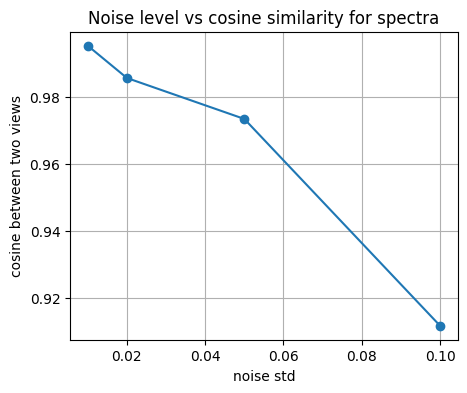

In [35]:
# Q4: noise sweep for spectra
levels = [0.01, 0.02, 0.05, 0.10]
scores = []
for lv in levels:
    def view_spectrum_lv(y, lv=lv):
        z = add_baseline(y, 0.0004)
        z = add_noise(z, lv)
        z = scale_intensity(z, 0.03)
        return normalize_minmax(z)
    v1 = view_spectrum_lv(spec_A)
    v2 = view_spectrum_lv(spec_A)
    scores.append(cos_sim(v1, v2))

plt.figure()
plt.plot(levels, scores, marker="o")
plt.xlabel("noise std")
plt.ylabel("cosine between two views")
plt.title("Noise level vs cosine similarity for spectra")
plt.show()

#### Q5 Solution

In [36]:
# Q5: linear probe after pretraining if possible
if torch is None:
    Ztr2 = sc.fit_transform(X_train)
    Zte2 = sc.transform(X_test)
else:
    enc.eval()
    with torch.no_grad():
        Ztr2 = enc(torch.from_numpy(X_train)).cpu().numpy()
        Zte2 = enc(torch.from_numpy(X_test)).cpu().numpy()
    Ztr2 = sc.fit_transform(Ztr2)
    Zte2 = sc.transform(Zte2)

clf2 = LogisticRegression(max_iter=500, random_state=0).fit(Ztr2, y_train)
proba2 = clf2.predict_proba(Zte2)[:,1]
pred2 = (proba2 >= 0.5).astype(int)
print("Accuracy:", round(accuracy_score(y_test, pred2),3))
print("AUC:", round(roc_auc_score(y_test, proba2),3))

Accuracy: 1.0
AUC: 1.0


### 10. Glossary

```{glossary}
Contrastive learning
  A method that trains an embedding so that two views of the same item are close and different items are far.

Positive pair
  Two augmented views of the same sample. They should remain close in the embedding.

Negative pair
  Two views from different samples. They should be far in the embedding.

Cosine similarity
  The dot product of normalized vectors. It measures alignment of directions.

Temperature
  A positive scalar in softmax that controls smoothness. Smaller values make distributions peakier.

InfoNCE loss
  A loss that maximizes agreement of the correct pair while contrasting against other items in the batch.

Linear probe
  A simple classifier trained on frozen embeddings to check if information is linearly recoverable.

Augmentation
  A transformation that preserves identity while adding variation such as noise or small jitters.

View
  The result of applying an augmentation to a sample. Two views of the same sample form a positive pair.

Retrieval
  Given a query in embedding space, return nearest neighbors by a similarity such as cosine.
```